In [587]:
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random

# Import Data from CSV

In [588]:
data = pd.read_csv('20210201_parsed_run3_data.csv',index_col=0)
# data['time'] -= 275.036 # let's start at 0 this shouldnt make a difference
# data['x'] -= data['x'][0]
# data['x'] *= -1
# data['y'] -= data['y'][0]
# data['psi'] += math.pi / 6
# data['delta'] = (data['steer'].shift(-1) - data['steer']) / (data['time'].shift(-1) - data['time']) 

In [589]:
data.head()

,time,x,y,psi,vx,vy,r,steer,D,real_ax,real_ay
0,0.00,-0.000000,0.000000,2.549214,20.914034,0.033644,-0.01642,0.000719,-0.254461,-0.2095,0.2194
1,0.04,-0.689575,0.474304,2.548682,20.925581,0.040599,-0.01548,0.001095,-0.271038,0.3387,-0.4859
2,0.08,-1.379486,0.948502,2.548225,20.920303,0.033280,-0.01133,0.001457,-0.306820,-0.2400,-0.1717
3,0.12,-2.069550,1.422333,2.547865,20.923943,0.040129,0.00004,0.001808,-0.256734,0.3106,-0.4829
4,0.16,-2.759766,1.896225,2.547584,20.925726,0.038360,-0.00244,0.002118,-0.289739,-0.1916,-0.7657


# Bicycle Model

In [590]:
def tire_force(alpha, Fz, p):
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p
    return -alpha * cornering_stiff * (Fz / sample_fz)

def normal_force(vx, p):
    g = 9.8
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p # params of the car
    # traction due to aero
    F_lift = 0.5*rho*cla*(vx**2)
    FzF = -(lr * (m * g + F_lift)) / l;
    FzR = -(lf * (m * g + F_lift)) / l;
    
    return FzF, FzR

def dynamic_model(t, x, p):
    x, y, psi, vx, vy, r, steer = x  # position
    D, delta = data['D'][int(t / 0.04)], data['delta'][int(t / 0.04)] # we will just take these based off the t input
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p # params of the car
    
    # estimate normal
    FzF, FzR = normal_force(vx, p)
    
    # compute slip angles
    alpha_f = math.atan((vy + r * lf) / vx) + steer
    alpha_r = math.atan((vy - r * lr) / vx)
    
    # compute tire forces
    F_yf = tire_force(alpha_f, FzF, p)
    F_yr = tire_force(alpha_r, FzR, p)
    
    # torque to force
    F_net = m * D
    
    # torque vectoring
    F_xf = lf / l * F_net
    F_xr = lr / l * F_net
    
    # accel
    ax = 1/m * (F_xr + F_xf * math.cos(steer) + F_yf * math.sin(steer)) + r * vy
    ay = 1/m * (F_yr - F_xf * math.sin(steer) + F_yf * math.cos(steer)) - r * vx
    a_yaw = 1/Iz * (-lf * F_xf * math.sin(steer) + lf * F_yf * math.cos(steer) - lr * F_yr)
    
    # bicycle model
    new_vx = vx * math.cos(psi) - vy * math.sin(psi)  # sin/cos(x), x should be radians.. not sure if our data is in deg/rad
    new_vy = vx * math.sin(psi) + vy * math.cos(psi)
    
    return [new_vx, new_vy, r, ax, ay, a_yaw, delta]
    
    
def kinematic_model(t, x, p):
    x, y, psi, vx, vy, r = x  # position
    D, steer = data['D'][math.floor(t / 0.04)], data['steer'][math.floor(t / 0.04)] # we will just take these based off the t input
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p # params of the car
    
    beta = math.atan((math.tan(-steer) * lr)/l)
    ax = D * math.cos(beta)
    ay = D * math.sin(beta)
    
    dx = vx * math.cos(psi + beta)
    dy = vx * math.sin(psi + beta)
    dpsi = math.tan(-steer) * (vx * math.cos(beta)) / l # Note: R.Rajamani uses opposite steering coordinates
    
    dvx = ax
    dvy = ay
    dr = vx / lr * math.sin(beta)
    
    return np.array([dx, dy, dpsi, ax, ay, dr])


In [604]:
# defining our variables for our simulated data
y0 = [data[c][0] for c in data.columns[1:7]]
timespan = 30
num_pts = 25*timespan + 1
tspan = np.linspace(0, timespan, num_pts)
p0 = (m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla) = (357, 2.971, 2.01, 0.960, 550.0, 125116, 4000, 1.225, -1.034)
# p0 = (m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla) = (350.0, 2.6, 1.2, 1.4, 550.0, 1000.0, 3430.0, 1.2, -0.5)

In [605]:
# dynamic model
# sol = solve_ivp(dynamic_model, (0, timespan), y0, t_eval=tspan, args=(p0,), rtol=1e-5, atol=1e-5)
# sol

In [606]:
sol = solve_ivp(kinematic_model, (0, timespan), y0, t_eval=tspan, args=(p0,), rtol=1e-5, atol=1e-5)
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 1850
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.  ,  0.04,  0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,
        0.36,  0.4 ,  0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,
        0.72,  0.76,  0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ,  1.04,
        1.08,  1.12,  1.16,  1.2 ,  1.24,  1.28,  1.32,  1.36,  1.4 ,
        1.44,  1.48,  1.52,  1.56,  1.6 ,  1.64,  1.68,  1.72,  1.76,
        1.8 ,  1.84,  1.88,  1.92,  1.96,  2.  ,  2.04,  2.08,  2.12,
        2.16,  2.2 ,  2.24,  2.28,  2.32,  2.36,  2.4 ,  2.44,  2.48,
        2.52,  2.56,  2.6 ,  2.64,  2.68,  2.72,  2.76,  2.8 ,  2.84,
        2.88,  2.92,  2.96,  3.  ,  3.04,  3.08,  3.12,  3.16,  3.2 ,
        3.24,  3.28,  3.32,  3.36,  3.4 ,  3.44,  3.48,  3.52,  3.56,
        3.6 ,  3.64,  3.68,  3.72,  3.76,  3.8 ,  3.84,  3.88,  3.92,
        3.96,  4.  ,  4.04,  4.08,  4.12,  4.16,  

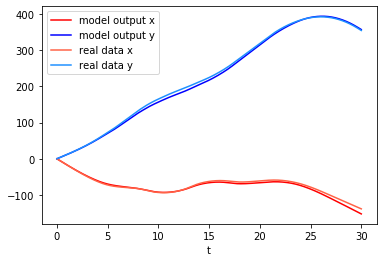

In [607]:
# let's plot this solution to see what it looks like against the real
plt.plot(tspan, sol.y[0,:], 'r', label='model output x')
plt.plot(tspan, sol.y[1,:], 'b', label='model output y')
plt.plot(tspan, data['x'][:num_pts], 'tomato', label='real data x')
plt.plot(tspan, data['y'][:num_pts], 'dodgerblue', label='real data y')
# plt.plot(t, sol[:, 2], 'g', label='model output psi')
# plt.plot(t, data['psi'][:num_pts], 'springgreen', label='real psi')


plt.legend(loc='best')
plt.xlabel('t')
plt.show()

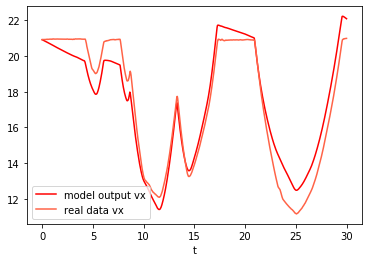

In [608]:
# let's plot this solution to see what it looks like against the real
plt.plot(tspan, sol.y[3,:], 'r', label='model output vx')
# plt.plot(tspan, sol.y[4,:], 'b', label='model output vy')
plt.plot(tspan, data['vx'][:num_pts], 'tomato', label='real data vx')
# plt.plot(tspan, data['vy'][:num_pts], 'dodgerblue', label='real data vy')
# plt.plot(t, sol[:, 2], 'g', label='model output psi')
# plt.plot(t, data['psi'][:num_pts], 'springgreen', label='real psi')


plt.legend(loc='best')
plt.xlabel('t')
plt.show()

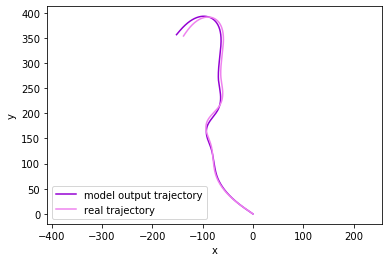

In [609]:
# let's plot just the xy trajectory
plt.plot(sol.y[0, :], sol.y[1, :], 'darkviolet', label='model output trajectory')
plt.plot(data['x'][:num_pts], data['y'][:num_pts], 'violet', label='real trajectory')
# plt.plot(data['x'], data['y'], 'violet', label='real trajectory')
plt.axis('equal')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Parameter Estimation

In [610]:
def plot_params(p):
    t = tspan
    pred_solver = solve_ivp(kinematic_model, (0, timespan), y0, t_eval=tspan, args=(p0,), rtol=1e-5, atol=1e-5)
    pred = pred_solver.y
    new_sol = np.swapaxes(pred, 0, 1)
#     new_sol = odeint(bicycle_model, u0, t, args=(p,))
    
    # let's plot this solution to see what it looks like against the real
    plt.plot(t, new_sol[:, 0], 'r', label='model output x')
    plt.plot(t, data['x'][:num_pts], 'tomato', label='real x')
    plt.plot(t, new_sol[:, 1], 'b', label='model output y')
    plt.plot(t, data['y'][:num_pts], 'dodgerblue', label='real y')
    plt.plot(t, new_sol[:, 2], 'g', label='model output psi')
    plt.plot(t, data['psi'][:num_pts], 'springgreen', label='real psi')


    plt.legend(loc='best')
    plt.xlabel('t')
    plt.show()
    
    # let's plot the velocity too
    plt.plot(t, new_sol[:, 3], 'r', label='model output vx')
    plt.plot(t, data['vx'][:num_pts], 'tomato', label='real vx')
    plt.plot(t, new_sol[:, 4], 'b', label='model output vy')
    plt.plot(t, data['vy'][:num_pts], 'dodgerblue', label='real vy')
    plt.plot(t, new_sol[:, 5], 'g', label='model output r')
    plt.plot(t, data['r'][:num_pts], 'springgreen', label='real r')


    plt.legend(loc='best')
    plt.xlabel('t')
    plt.show()
    
    
    # let's plot just the xy trajectory
    plt.plot(new_sol[:, 0], new_sol[:, 1], 'darkviolet', label='model output trajectory')
    plt.plot(data['x'][:num_pts], data['y'][:num_pts], 'violet', label='real trajectory')
    plt.legend(loc='best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [611]:
pred_solver = solve_ivp(kinematic_model, (0, timespan), y0, t_eval=tspan, args=(p0,), rtol=1e-5, atol=1e-5)
pred = pred_solver.y
pred = np.swapaxes(pred, 0, 1)
pred.shape

(751, 6)

In [612]:
sol = data[data.time.between(0, timespan)][data.columns[1:7]].to_numpy()

In [613]:
sol.shape

(751, 6)

In [614]:
pred[:5, [0, 1, 3, 4]]  # let's not try to match angles

array([[ 0.        ,  0.        , 20.91403389,  0.03364359],
       [-0.69369335,  0.46720722, 20.90374793,  0.03364609],
       [-1.38686091,  0.93442251, 20.89233081,  0.03365016],
       [-2.07942278,  1.40169363, 20.88008422,  0.03365584],
       [-2.77132388,  1.86905911, 20.86758487,  0.03366275]])

In [615]:
# TODO: probably want to normalize this error
# l2 = np.square(sol - pred).sum()

def cost(p):
#     pred = odeint(bicycle_model, u0, t, args=(p,))
    pred_solver = solve_ivp(kinematic_model, (0, timespan), y0, t_eval=tspan, args=(p,), rtol=1e-5, atol=1e-5)
    pred = pred_solver.y
    pred = np.swapaxes(pred, 0, 1)
    return np.square(sol[:,[0, 1, 3, 4]] - pred[:,[0, 1, 3, 4]]).sum()

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


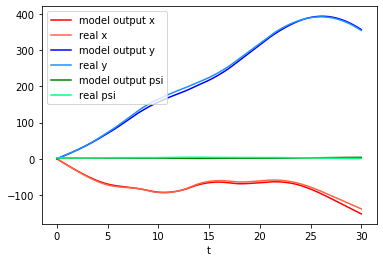

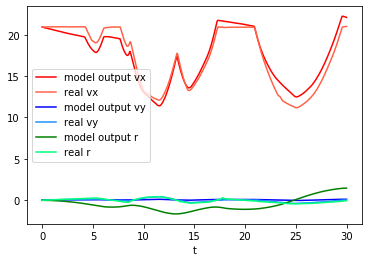

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


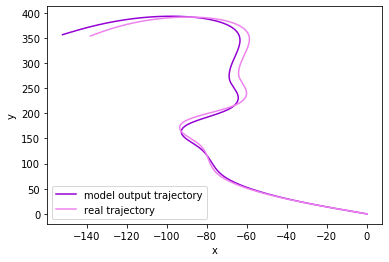

In [616]:
plot_params(p0)

In [622]:
minimization = minimize(cost, p0, method='Nelder-Mead', options={'maxiter':1e5})

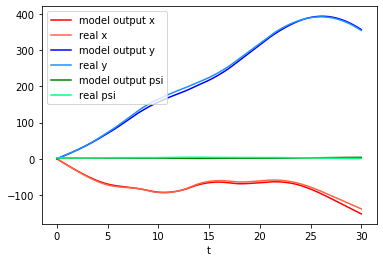

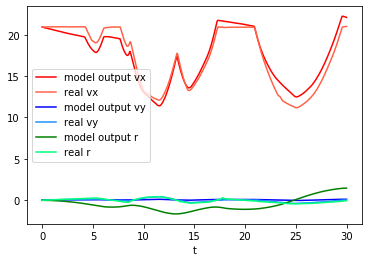

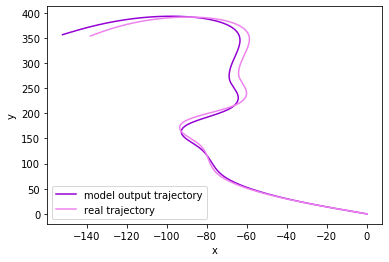

In [626]:
plot_params(p0)

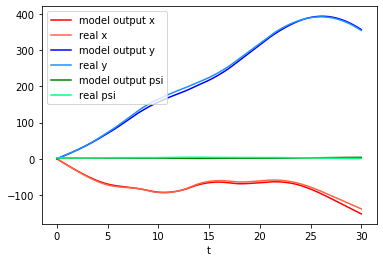

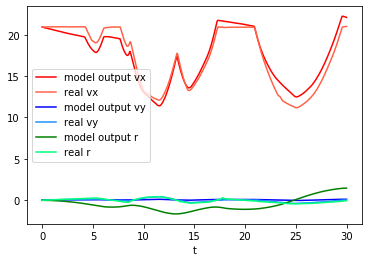

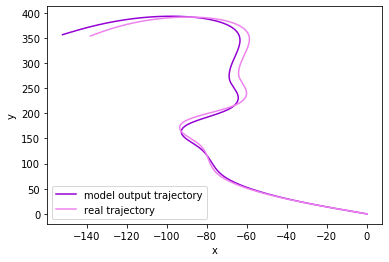

In [627]:
plot_params(tuple(minimization.x))

In [628]:
# m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla
minimization.x
# p0 = (357, 2.971, 2.01, 0.960, 550.0, 125116, 4000, 1.225, -1.034)

array([ 3.69433199e+02,  2.91606173e+00,  2.07596753e+00,  9.41224753e-01,
        5.67377170e+02,  1.20782095e+05,  3.96345251e+03,  1.23218017e+00,
       -1.02252576e+00])

In [630]:
print(list(minimization.x))

[369.43319933949994, 2.9160617304598766, 2.075967531884608, 0.941224752729082, 567.3771703339255, 120782.09528177136, 3963.452513162594, 1.2321801663368814, -1.022525760289843]


In [586]:
# TODO list:
# - x is going in wrong direction
# - cost function normalization
# - add constraints to the parameters in the minimization
# - make a velocity graph too to observe velocities

# note to self that just matching velocities did not perform so hot lol